In [67]:
import os
import pickle
import numpy as np
import xgboost as xgb
import pandas as pd

n_bootstrap = 100

ft_dir = 'features_long/'

# list feature files
files = os.listdir(ft_dir)

with open('top_locations.dat') as f:
    state_top10 = pickle.load(f)
f.close()
for (i,s) in enumerate(state_top10):
    state_top10[i] = state_top10[i].replace('"','')
    state_top10[i] = state_top10[i].replace('[','')
    state_top10[i] = state_top10[i].replace(']','')

feature_all = []
state_all = []
state_fsq_all = []
for filename in files:
    with open(ft_dir+filename) as f:  
        feature, state = pickle.load(f)
        
        # only keeping top 10 states
        ind = np.array([], int)
        for (i,st) in enumerate(state['location']):
            if st in state_top10:
                ind = np.append(ind, i)
        feature = feature.loc[ind,:]
        state = state.loc[ind,'location']
        
        feature = feature.reset_index(drop = True)
        state = state.reset_index(drop = True)
        
        feature_all.append(feature)
        state_all.append(state)
        
    f.close()

inds = np.arange(0,len(feature_all),1)
inds_split = np.floor(0.7*len(feature_all))
    
gbm = [[] for _ in range(n_bootstrap)]
for sd in range(n_bootstrap):
    print sd,
#     np.random.shuffle(inds)
#     ind_train = inds[:inds_split]
#     x_train = pd.concat([feature_all[j] for j in ind_train], axis=0)
#     y_train = pd.concat([state_all[j] for j in ind_train], axis=0)

    # one sample per subject
#     x_train = pd.DataFrame(columns=feature_all[0].columns)
#     y_train = pd.Series(name=state_all[0].name)
#     for i in range(len(feature_all)):
#         ind = np.random.choice(np.arange(feature_all[i].shape[0]),size=1)
#         x_train = pd.concat([x_train, feature_all[i].loc[ind,:]], axis=0)
#         y_train = pd.concat([y_train, state_all[i].loc[ind]], axis=0)
#         x_train = x_train.reset_index(drop = True)
#         y_train = y_train.reset_index(drop = True)
    
    # one class sampled from each subject
    x_train = pd.DataFrame(columns=feature_all[0].columns)
    y_train = pd.Series(name=state_all[0].name)
    for i in range(len(feature_all)):
        state_uniq = np.unique(state_all[i])
        ind_uniq = np.random.choice(np.arange(state_uniq.size),size=1)[0]
        ind = (state_all[i]==state_uniq[ind_uniq])
        x_train = pd.concat([x_train, feature_all[i].loc[ind,:]], axis=0)
        y_train = pd.concat([y_train, state_all[i].loc[ind]], axis=0)
        x_train = x_train.reset_index(drop = True)
        y_train = y_train.reset_index(drop = True)

    gbm[sd] = xgb.XGBClassifier(max_depth=6, n_estimators=75, learning_rate=0.05, nthread=12, subsample=0.25, \
                        colsample_bytree=0.2, max_delta_step=0, gamma=3, objective='mlogloss', reg_alpha=0.5, \
                        missing=np.nan).fit(x_train, y_train)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


In [72]:
auc_ref

NameError: name 'auc_ref' is not defined

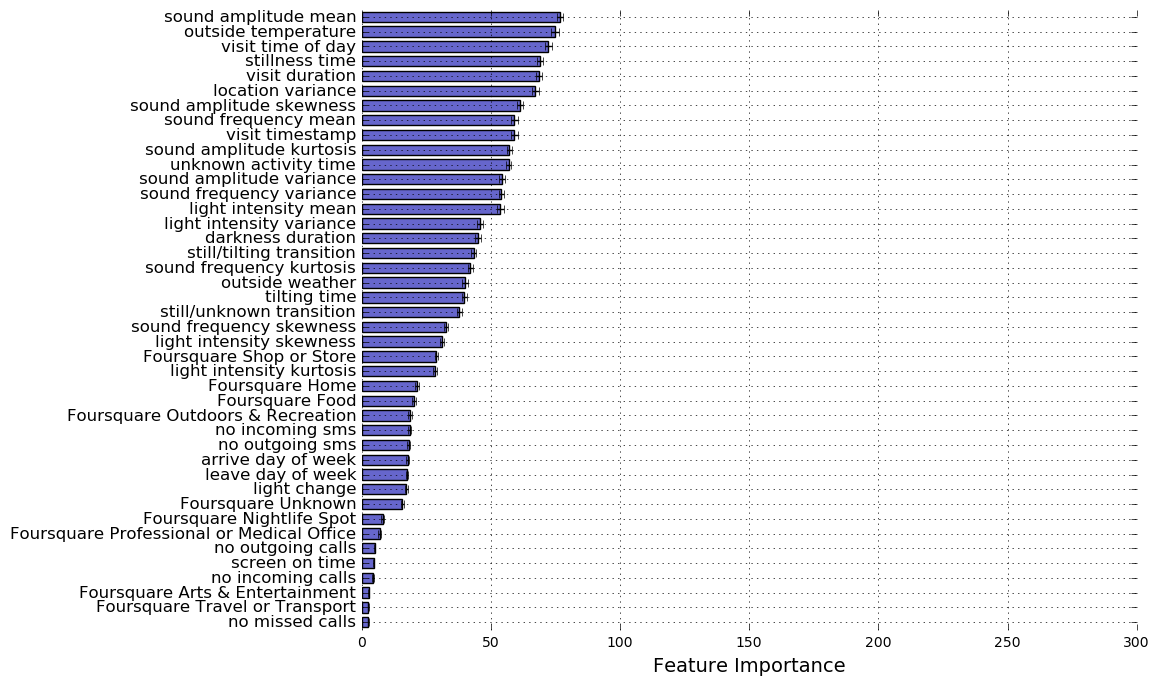

In [68]:
import matplotlib.pyplot as plt
import numpy as np

dic = {'lgt mean':'light intensity mean', 'lgt std':'light intensity variance', 'lgt off':'darkness duration', 'lgt zcrossing':'light change',\
       'lgt skew':'light intensity skewness', 'lgt kurt':'light intensity kurtosis', 'aud mean':'sound amplitude mean', \
       'aud std':'sound amplitude variance', 'aud skew':'sound amplitude skewness', 'aud kurt':'sound amplitude kurtosis',\
       'aud frq mean':'sound frequency mean', 'aud frq std':'sound frequency variance', 'aud frq skew':'sound frequency skewness',\
       'aud frq kurt':'sound frequency kurtosis', 'scr frq':'screen on/off frequency', 'scr dur mean':'screen on time', \
       'scr dur std':'screen on time variance', 'still':'stillness time', 'tilting':'tilting time', 'walking':'walking time',\
       'unknown act':'unknown activity time', 'still-walking':'still/walking transition', 'still-tilting':'still/tilting transition',\
       'still-unknown':'still/unknown transition', 'walking-unknown':'walking/unknown transition', 'call in':'no incoming calls', 'call out':\
       'no outgoing calls', 'sms in':'no incoming sms', 'sms out':'no outgoing sms', 'call missed':'no missed calls', 'n wifi':\
       'no wifi nets', 'temperature':'outside temperature', 'dew point':'outside windchill', 'weather':'outside weather', \
       'lat mean':'latitude mean', 'lng mean':'longitude mean', 'loc var':'location variance', 'duration':'visit timespan',\
       'midtime':'visit timestamp', 'midhour':'visit time of day', 'dow start':'arrive day of week', 'dow end':\
       'leave day of week', 'fsq 0':'Foursquare Nightlife Spot', 'fsq 1':'Foursquare Outdoors & Recreation', 'fsq 2':'Foursquare Arts & Entertainment'\
       , 'fsq 3':'Foursquare Professional or Medical Office', 'fsq 4':'Foursquare Food', 'fsq 5':'Foursquare Home', \
       'fsq 6':'Foursquare Shop or Store', 'fsq 7':'Foursquare Travel or Transport', 'fsq 8':'Foursquare Unknown', 'fsq distance':\
       'Foursquare distance', 'LT frequency':'visit frequency', 'LT interval mean':'mean time between visits', 'n gps':'visit duration'}

# extracting means and CIs
feature_label = x_train.columns

fscore = pd.DataFrame(index=np.arange(n_bootstrap), columns=feature_label)
for i in range(n_bootstrap):
    keys = np.array(gbm[i].booster().get_fscore().keys())
    vals = np.array(gbm[i].booster().get_fscore().values()).astype(float)
    for lab in feature_label:
        ind = np.where(keys==lab)[0]
        if ind.size>0:
            fscore.loc[i,lab] = vals[ind[0]]
fscore_mean = np.array(fscore.mean(axis=0))
fscore_ci = np.array(fscore.std(axis=0)/np.sqrt(n_bootstrap))
ind_sort = np.array(np.argsort(fscore_mean))
val_sorted = fscore_mean[ind_sort]
ci_sorted = fscore_ci[ind_sort]
feature_label_sorted = feature_label[ind_sort]
feature_label_short = []
for i in range(feature_label_sorted.size):
    feature_label_short.append(dic[feature_label_sorted[i]])
    
%matplotlib inline
plt.figure(figsize=(10,8))
axes = plt.gca()
plt.barh(np.arange(val_sorted.size), val_sorted, xerr=ci_sorted, height=.7, color=(.4,.4,.8), align='center', ecolor=(0,0,0))
plt.yticks(np.arange(len(feature_label_short)), feature_label_short, fontsize=12, color=(0,0,0));
axes.set_ylim([3.5, len(feature_label_short)-9.5])
plt.box(on=False)
plt.xlabel('Feature Importance',fontsize=14)
plt.grid()

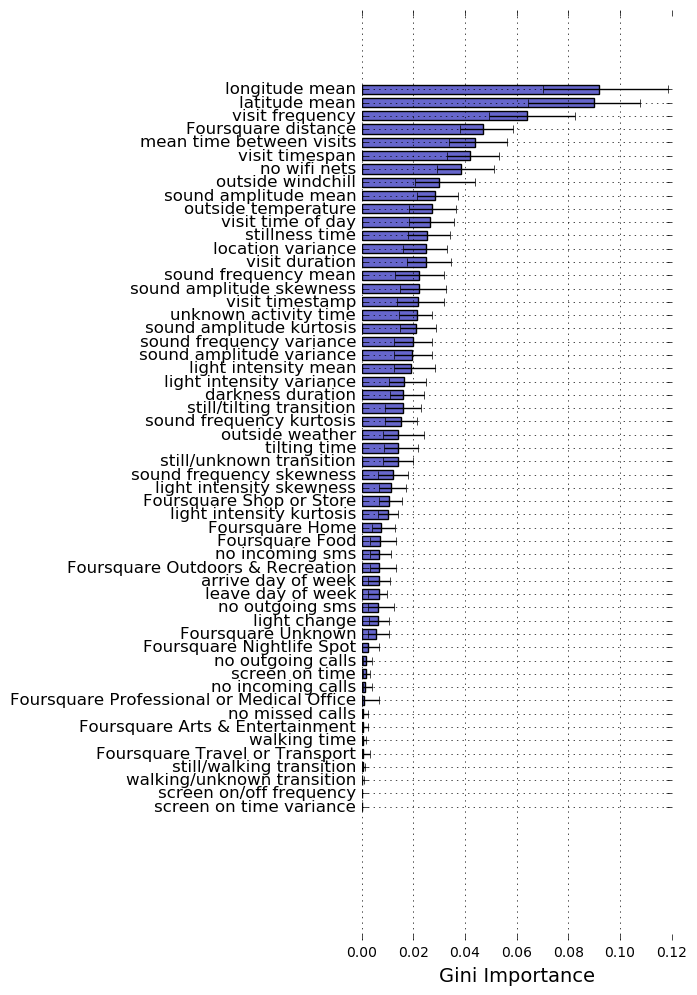

In [69]:
# extracting means and CIs
feature_label = x_train.columns

fscore = pd.DataFrame(index=np.arange(n_bootstrap), columns=feature_label)
for i in range(n_bootstrap):
    fscore.loc[i,:] = gbm[i].feature_importances_
fscore_mean = np.median(fscore, axis=0)
# fscore_ci = np.array(fscore.std(axis=0)/np.sqrt(n_bootstrap))
fscore_lo = np.percentile(fscore, 2.5, axis=0)
fscore_hi = np.percentile(fscore, 97.5, axis=0)
ind_sort = np.array(np.argsort(fscore_mean))
fscore_mean_sorted = fscore_mean[ind_sort]
# ci_sorted = fscore_ci[ind_sort]
fscore_lo_sorted = fscore_lo[ind_sort]
fscore_hi_sorted = fscore_hi[ind_sort]
feature_label_sorted = feature_label[ind_sort]
feature_label_short = []
for i in range(feature_label_sorted.size):
    feature_label_short.append(dic[feature_label_sorted[i]])
    
%matplotlib inline
plt.figure(figsize=(4,12))
axes = plt.gca()
# plt.barh(np.arange(val_sorted.size), val_sorted, xerr=ci_sorted, height=.7, color=(.4,.4,.8), align='center', ecolor=(0,0,0))
plt.barh(np.arange(fscore_mean_sorted.size), fscore_mean_sorted, \
         xerr=np.array([fscore_mean_sorted-fscore_lo_sorted,fscore_hi_sorted-fscore_mean_sorted]), \
         height=.7, color=(.4,.4,.8), align='center', ecolor=(0,0,0))
plt.yticks(np.arange(len(feature_label_short)), feature_label_short, fontsize=12, color=(0,0,0));
# axes.set_ylim([3.5, len(feature_label_short)-9.5])
# axes.set_xlim([0, 0.04])
plt.box(on=False)
plt.xlabel('Gini Importance',fontsize=14)
plt.grid()

In [49]:
np.percentile(fscore, 2.5, axis=0)
xgb.plot_importance()

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01289757820777595,
       0.014177189790643752, 0.0, 0.0, 0.0, 0.003145695361308754, 0.0, 0.0,
       0.0, 0.006022500479593873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0027941177017055457, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.09166666753590108, 0.0, 0.002896341355517507, 0.0, 0.0,
       0.0211472044698894, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.005904088017996401, 0.0, 0.0, 0.014649527659639717,
       0.048471934720873834, 0.05939175765961409], dtype=object)